In [1]:
import pandas as pd 
import json 

# construct variable

## monthly growth in the nominal exchange rate

In [2]:
# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find the row index where "Exchange Rates, National Currency Per U.S. Dollar" appears
exchange_rate_row = df[df.iloc[:, 1].str.contains("Exchange Rates", na=False)].index[0]

# Extract the relevant row (France's exchange rate data)
exchange_rate_data = df.iloc[exchange_rate_row, 1:].reset_index(drop=True)

# Convert values to numeric (ignore the first value, which is text)
exchange_rate_data = pd.to_numeric(exchange_rate_data[1:], errors="coerce")

# Drop NaN values
exchange_rate_data.dropna(inplace=True)


In [27]:
# Compute the monthly growth rate in percentage
monthly_growth = exchange_rate_data.pct_change() * 100

# Convert to DataFrame for better visualization
monthly_growth_df = pd.DataFrame({
    "Month": range(1, len(monthly_growth) + 1),
    "Growth (%)": monthly_growth.values
})

# Display the first few rows
display(monthly_growth_df)
monthly_growth_df.to_json('../Data/monthly_nominal_exchange_rate_growth.json', orient='records', indent=4)


,Month,Growth (%)
0,1,NaN
1,2,0.000000
2,3,0.000000
3,4,0.000000
4,5,0.000000
...,...,...
368,369,-4.134170
369,370,-0.295841
370,371,-2.900618
371,372,-2.047013


## Real exchange rate

In [4]:
# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices dynamically
exchange_rate_row = df[df.iloc[:, 1].str.contains("Exchange Rates", na=False)].index[0]
france_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract data
exchange_rate = pd.to_numeric(df.iloc[exchange_rate_row, 2:], errors="coerce")
france_cpi = pd.to_numeric(df.iloc[france_cpi_row, 2:], errors="coerce")
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")

# Drop NaN values (optional, depending on data quality)
exchange_rate.dropna(inplace=True)
france_cpi.dropna(inplace=True)
us_cpi.dropna(inplace=True)

# Compute Real Exchange Rate (RER)
rer = exchange_rate * (us_cpi / france_cpi)

# Compute Monthly Growth in RER
monthly_growth_rer = rer.pct_change() * 100  # Convert to percentage

# Convert to DataFrame for better visualization
monthly_growth_rer_df = pd.DataFrame({
    "Month": range(1, len(monthly_growth_rer) + 1),
    "Real Exchange Rate Growth (%)": monthly_growth_rer.values
})

# Display the first few rows
print(monthly_growth_rer_df.head())


   Month  Real Exchange Rate Growth (%)
0      1                            NaN
1      2                      -1.642377
2      3                       0.110462
3      4                       0.000000
4      5                       0.186470


## An index of the real exchange rate (setting the real exchange rate for December 1990 = 1)

In [5]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Print the first few rows to inspect structure
print(df.head())

# Extract the date row (assuming it's the first row)
date_row = df.iloc[0, 2:].astype(str).str.strip()

# Print unique values to check format
display("\nRaw date row values:\n", date_row.unique())


                                        0    \
0  International Financial Statistics (IFS)   
1                                       NaN   
2                                    France   
3                                    France   
4                                    France   

                                                 1          2          3    \
0                                                NaN        NaN        NaN   
1                                                NaN   Dec 1959   Jan 1960   
2    Economic Activity, Industrial Production, Index  35.365725  33.997257   
3  Exchange Rates, National Currency Per U.S. Dol...    4.93706    4.93706   
4  International Reserves and Liquidity, Reserves...    1735.74    1753.74   

         4          5          6          7          8          9    ...  \
0        NaN        NaN        NaN        NaN        NaN        NaN  ...   
1   Feb 1960   Mar 1960   Apr 1960   May 1960   Jun 1960   Jul 1960  ...   
2  34.793828  34.916

'\nRaw date row values:\n'

array(['nan'], dtype=object)

In [6]:
# Try parsing month-year format first
dates = pd.to_datetime(date_row, format="%b %Y", errors="coerce")

# Handle pure year values separately (if parsing failed)
dates.loc[dates.isna()] = pd.to_datetime(date_row.loc[dates.isna()], format="%Y", errors="coerce")

# Print parsed dates
print("\nParsed dates:\n", dates.dropna().unique())



Parsed dates:
 <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]


In [7]:
df = pd.read_excel(file_path, engine="openpyxl", skiprows=1)  # Skip first row

print("Column Headers:", df.columns)


Column Headers: Index(['Unnamed: 0', 'Unnamed: 1', 'Dec 1959', 'Jan 1960', 'Feb 1960',
       'Mar 1960', 'Apr 1960', 'May 1960', 'Jun 1960', 'Jul 1960',
       ...
       'Mar 1990', 'Apr 1990', 'May 1990', 'Jun 1990', 'Jul 1990', 'Aug 1990',
       'Sep 1990', 'Oct 1990', 'Nov 1990', 'Dec 1990'],
      dtype='object', length=375)


In [8]:
# Identify columns that are four-digit years
year_only_columns = df.columns[2:][df.columns[2:].astype(str).str.match(r"^\d{4}$")]

# Drop these columns
df_cleaned = df.drop(columns=year_only_columns)

In [9]:
# Load data (skipping first row)
df = pd.read_excel(file_path, engine="openpyxl", skiprows=1)

# Extract only potential date columns (excluding the first two columns)
raw_date_headers = df.columns[2:]  # Ignore first two non-date columns

# Filter out standalone years (keep only "Month Year" format)
filtered_dates = [col for col in raw_date_headers if not col.isdigit()]  # Remove pure years

# Convert the filtered date headers to datetime
dates = pd.to_datetime(filtered_dates, format="%b %Y", errors="coerce")

# Debug: Check parsed dates
print("Parsed Dates:", dates)

# ✅ FIX: Remove .dt from DatetimeIndex
dec_1990_index = (dates.year == 1990) & (dates.month == 12)

if dec_1990_index.sum() == 0:
    raise ValueError(f"December 1990 not found! Check the parsed dates: {dates}")

print("December 1990 found at index:", dec_1990_index.argmax())


Parsed Dates: DatetimeIndex(['1959-12-01', '1960-01-01', '1960-02-01', '1960-03-01',
               '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01',
               '1960-08-01', '1960-09-01',
               ...
               '1990-03-01', '1990-04-01', '1990-05-01', '1990-06-01',
               '1990-07-01', '1990-08-01', '1990-09-01', '1990-10-01',
               '1990-11-01', '1990-12-01'],
              dtype='datetime64[ns]', length=373, freq=None)
December 1990 found at index: 372


In [10]:
# Extract the real exchange rate (RER) series
rer_series = rer.values  # Assuming `rer` is already computed

# Get RER value for December 1990
rer_dec_1990 = rer_series[372]

# Normalize the RER series to set Dec 1990 = 1
rer_index = rer_series / rer_dec_1990


In [11]:
rer_series = rer_series[:len(dates)]


In [12]:
print(f"Length of dates: {len(dates)}")
print(f"Length of rer_series: {len(rer_series)}")


Length of dates: 373
Length of rer_series: 373


In [13]:
rer_index_df = pd.DataFrame({
    "Date": dates,  
    "RER Index": rer_series
})


In [14]:
print(rer_index_df.head())

        Date  RER Index
0 1959-12-01   6.520281
1 1960-01-01   6.413193
2 1960-02-01   6.420277
3 1960-03-01   6.420277
4 1960-04-01   6.432249


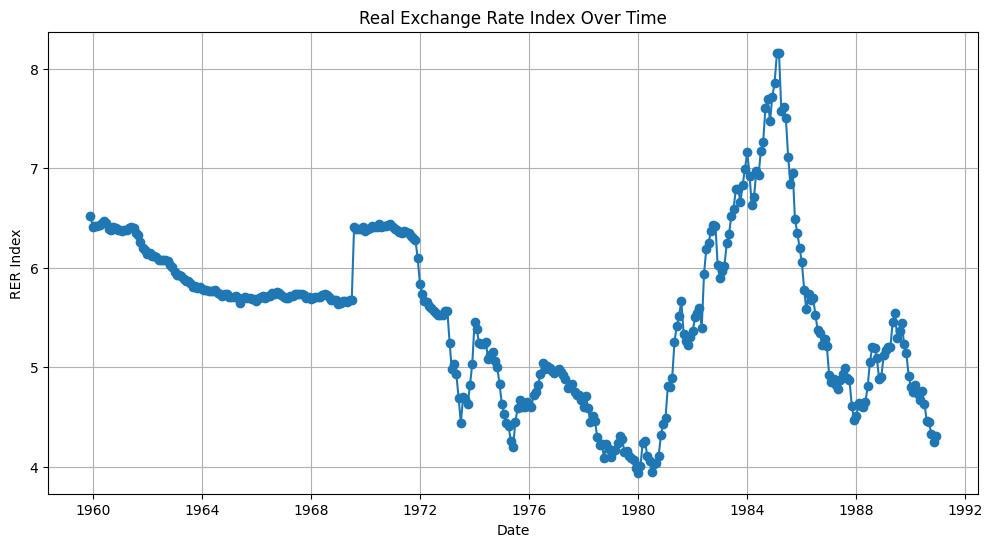

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(rer_index_df["Date"], rer_index_df["RER Index"], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("RER Index")
plt.title("Real Exchange Rate Index Over Time")
plt.grid()
plt.show()


## monthly inflation rate

In [16]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US CPI dynamically
france_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract CPI data
france_cpi = pd.to_numeric(df.iloc[france_cpi_row, 2:], errors="coerce")
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")

# Compute Monthly Inflation Rate (percentage change)
france_inflation = france_cpi.pct_change() * 100
us_inflation = us_cpi.pct_change() * 100

# Create DataFrame for visualization
inflation_df = pd.DataFrame({
    "Month": range(1, len(france_inflation) + 1),
    "France Inflation (%)": france_inflation.values,
    "US Inflation (%)": us_inflation.values
})

# Display first few rows
print(inflation_df)


     Month  France Inflation (%)  US Inflation (%)
0        1                   NaN               NaN
1        2              1.323986         -0.340136
2        3              0.230580          0.341297
3        4              0.000000          0.000000
4        5              0.153380          0.340136
..     ...                   ...               ...
368    369              0.654762          0.920245
369    370              0.709639          0.835866
370    371              0.440399          0.602864
371    372             -0.160772          0.224719
372    373             -0.073196          0.000000

[373 rows x 3 columns]


## The monthly growth in industrial production

In [17]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US Industrial Production dynamically
france_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract Industrial Production Index data
france_ip = pd.to_numeric(df.iloc[france_ip_row, 2:], errors="coerce")
us_ip = pd.to_numeric(df.iloc[us_ip_row, 2:], errors="coerce")

# Compute Monthly Growth in Industrial Production (percentage change)
france_ip_growth = france_ip.pct_change() * 100
us_ip_growth = us_ip.pct_change() * 100

# Create DataFrame for visualization
industrial_production_df = pd.DataFrame({
    "Month": range(1, len(france_ip_growth) + 1),
    "France IP Growth (%)": france_ip_growth.values,
    "US IP Growth (%)": us_ip_growth.values
})

# Display first few rows
print(industrial_production_df)


     Month  France IP Growth (%)  US IP Growth (%)
0        1                   NaN               NaN
1        2             -3.869477          2.917232
2        3              2.343046          0.560316
3        4              0.352216         -0.229433
4        5              2.281369         -0.788436
..     ...                   ...               ...
368    369            -25.892857          3.346457
369    370             38.855422          0.761905
370    371             10.195228         -1.348456
371    372             -5.216535         -2.593255
372    373             -4.880582         -1.468852

[373 rows x 3 columns]


## The growth in industrial production versus 12 months ago (i.e. January 1971 versus January 1970 etc.)


In [18]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US Industrial Production dynamically
france_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract Industrial Production Index data
france_ip = pd.to_numeric(df.iloc[france_ip_row, 2:], errors="coerce")
us_ip = pd.to_numeric(df.iloc[us_ip_row, 2:], errors="coerce")

# Compute Year-over-Year (YoY) Growth in Industrial Production
france_ip_yoy_growth = france_ip.pct_change(periods=12) * 100
us_ip_yoy_growth = us_ip.pct_change(periods=12) * 100

# Create DataFrame for visualization
industrial_production_yoy_df = pd.DataFrame({
    "Month": range(1, len(france_ip_yoy_growth) + 1),
    "France YoY IP Growth (%)": france_ip_yoy_growth.values,
    "US YoY IP Growth (%)": us_ip_yoy_growth.values
})

# Display first few rows
print(industrial_production_yoy_df)


     Month  France YoY IP Growth (%)  US YoY IP Growth (%)
0        1                       NaN                   NaN
1        2                       NaN                   NaN
2        3                       NaN                   NaN
3        4                       NaN                   NaN
4        5                       NaN                   NaN
..     ...                       ...                   ...
368    369                  4.097257              1.915362
369    370                  4.818828              2.506136
370    371                  5.340079              1.768071
371    372                 -0.058014              0.302552
372    373                 -1.578180             -1.326504

[373 rows x 3 columns]


## An index of the value of international reserves (value of reserves for January 1960 = 100)

In [19]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and U.S. International Reserves
france_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract International Reserves data
france_reserves = pd.to_numeric(df.iloc[france_reserves_row, 2:], errors="coerce")
us_reserves = pd.to_numeric(df.iloc[us_reserves_row, 2:], errors="coerce")

# Find the value of reserves in January 1960 (assumes the first column is Jan 1960)
jan_1960_index = 2  # Assuming the first data column corresponds to Jan 1960
france_reserves_jan_1960 = france_reserves.iloc[jan_1960_index]
us_reserves_jan_1960 = us_reserves.iloc[jan_1960_index]

# Construct the Index (Normalize to Jan 1960 = 100)
france_reserves_index = (france_reserves / france_reserves_jan_1960) * 100
us_reserves_index = (us_reserves / us_reserves_jan_1960) * 100

# Create DataFrame for visualization
reserves_index_df = pd.DataFrame({
    "Month": range(1, len(france_reserves_index) + 1),
    "France Reserves Index": france_reserves_index.values,
    "US Reserves Index": us_reserves_index.values
})

# Display first few rows
print(reserves_index_df)


     Month  France Reserves Index  US Reserves Index
0        1              96.604962         100.508513
1        2              97.606777         100.385124
2        3             100.000000         100.000000
3        4             104.064027          99.761634
4        5             108.406892          99.449889
..     ...                    ...                ...
368    369            3279.167057         368.806996
369    370            3459.655053         374.019855
370    371            3593.424484         387.237606
371    372            3703.018203         388.206054
372    373            3790.137149         389.406351

[373 rows x 3 columns]


# US

In [20]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices dynamically
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]
us_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract U.S. data
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")
us_reserves = pd.to_numeric(df.iloc[us_reserves_row, 2:], errors="coerce")

# (i) Compute Monthly Inflation Rate
us_inflation_rate = us_cpi.pct_change() * 100  # Convert to percentage

# (ii) Compute International Reserves Index (Jan 1960 = 100)
jan_1960_index = 2  # Assuming first data column corresponds to Jan 1960
us_reserves_jan_1960 = us_reserves.iloc[jan_1960_index]
us_reserves_index = (us_reserves / us_reserves_jan_1960) * 100

# Create DataFrame for visualization
us_data_df = pd.DataFrame({
    "Month": range(1, len(us_cpi) + 1),
    "US Inflation Rate (%)": us_inflation_rate.values,
    "US Reserves Index": us_reserves_index.values
})

# Display first few rows
print(us_data_df)


     Month  US Inflation Rate (%)  US Reserves Index
0        1                    NaN         100.508513
1        2              -0.340136         100.385124
2        3               0.341297         100.000000
3        4               0.000000          99.761634
4        5               0.340136          99.449889
..     ...                    ...                ...
368    369               0.920245         368.806996
369    370               0.835866         374.019855
370    371               0.602864         387.237606
371    372               0.224719         388.206054
372    373               0.000000         389.406351

[373 rows x 3 columns]


## Identify outliers

In [21]:
import pandas as pd
import numpy as np

# Function to detect and replace outliers
def detect_outliers(series, method="IQR"):
    if method == "IQR":
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series.mask((series < lower_bound) | (series > upper_bound), np.nan)
    
    elif method == "Z-score":
        mean = series.mean()
        std = series.std()
        z_scores = (series - mean) / std
        return series.mask((z_scores < -3) | (z_scores > 3), np.nan)

# Apply outlier detection to each data series
exchange_rate_clean = detect_outliers(exchange_rate)
france_cpi_clean = detect_outliers(france_cpi)
us_cpi_clean = detect_outliers(us_cpi)
industrial_production_clean = detect_outliers(industrial_production)
international_reserves_clean = detect_outliers(international_reserves)
rer_growth_clean = detect_outliers(monthly_growth_rer)
industrial_production_growth_clean = detect_outliers(industrial_production_growth)
industrial_production_12m_clean = detect_outliers(industrial_production_12m)
us_inflation_rate_clean = detect_outliers(us_inflation_rate)

# Create DataFrame for cleaned data
cleaned_data = pd.DataFrame({
    "Exchange Rate": exchange_rate_clean,
    "France CPI": france_cpi_clean,
    "US CPI": us_cpi_clean,
    # "Industrial Production": industrial_production_clean,
    # "International Reserves": international_reserves_clean,
    # "RER Growth (%)": rer_growth_clean,
    # "Industrial Production Growth (%)": industrial_production_growth_clean,
    # "12-Month Industrial Production Growth (%)": industrial_production_12m_clean,
    "US Inflation Rate (%)": us_inflation_rate_clean
})

# Display summary
print(cleaned_data.describe())


NameError: name 'industrial_production' is not defined

## Question 5 
### Zhu Zhu - changes to question 4 to be made above, dont put anything of Q4 here

 For the graphs in 5.2, you should clearly indicate the time at which your country left the Bretton
 Woods system if it is sensible to do so and show the relevant data for every month from January 1960
 to December 1990

 5.2.1 Exchange Rate and International Reserve Graphs

 Plot the following time series graphs for your country versus the US dollar, presenting all the graphs
 together:

 • The monthly growth in the nominal exchange rate - used Ming's numbers

 • The level of the nominal exchange rate - im j taking raw nominal data idk what else it would be?

 • The monthly growth in the real exchange rate.

 • The real exchange rate index

In [29]:
import pandas as pd
import sqlite3
import json
import numpy as np
from lets_plot import *
LetsPlot.setup_html()

In [37]:
df_graph_1 = pd.read_json('../Data/monthly_nominal_exchange_rate_growth.json')

# Display the first few rows
display(df_graph_1.head())

,Month,Growth (%)
0,1,NaN
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [41]:
df_graph_1['Growth (%)'] = pd.to_numeric(df_graph_1['Growth (%)'], errors='coerce')
df_graph_1 = df_graph_1.dropna(subset=['Growth (%)'])
df_graph_1['Growth (%)'].fillna(0, inplace=True)

a =   ggplot(df_graph_1, aes(x='Month', y='Growth (%)')) + \
        geom_line(color='blue', size=1) + \
        labs(title='Monthly Nominal Growth Over Time', x='Month', y='Growth (%)') + \
        ggsize(800, 400)

display(a)

C:\Users\eleph\AppData\Local\Temp\ipykernel_33556\610503480.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_graph_1['Growth (%)'].fillna(0, inplace=True)


In [51]:
nominal_rate_df = pd.read_excel(file_path, header=1, engine="openpyxl")
nominal_rate_df.columns = nominal_rate_df.columns.astype(str)

# Select only relevant columns (not four-digit years) and filter for France Exchange Rates
monthly_cols = [x for x in nominal_rate_df.columns if not (x.strip().isdigit() and len(x.strip()) == 4)]
filtered_df = nominal_rate_df.loc[(nominal_rate_df.iloc[:, 0] == 'France') & 
                      (nominal_rate_df.iloc[:, 1].str.contains('Exchange Rates', na=False)), monthly_cols]

# Melt and reshape the data
df_graph_2 = pd.melt(filtered_df, id_vars=['Unnamed: 0', 'Unnamed: 1'], 
                    var_name='Date', value_name='Exchange Rate')[['Date', 'Exchange Rate']]

# Display the result
display(df_graph_2)

,Date,Exchange Rate
0,Dec 1959,4.93706
1,Jan 1960,4.93706
2,Feb 1960,4.93706
3,Mar 1960,4.93706
4,Apr 1960,4.93706
...,...,...
368,Aug 1990,5.27310
369,Sep 1990,5.25750
370,Oct 1990,5.10500
371,Nov 1990,5.00050


In [54]:
df_graph_2['Exchange Rate'] = pd.to_numeric(df_graph_2['Exchange Rate'], errors='coerce')
df_graph_2 = df_graph_2.dropna(subset=['Exchange Rate'])
df_graph_2['Exchange Rate'].fillna(0, inplace=True)

b =   ggplot(df_graph_2, aes(x='Date', y='Exchange Rate')) + \
        geom_line(color='red', size=1) + \
        labs(title='Monthly Nominal Exchange Rate Over Time', x='Date', y='Nominal Exchange Rate') + \
        ggsize(800, 400)

display(b)

C:\Users\eleph\AppData\Local\Temp\ipykernel_33556\2198901466.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_graph_2['Exchange Rate'].fillna(0, inplace=True)
